# Parameter learning in SNN with Norse

Norse explores an excillerating playground that exists somewhere between regular deep learning and biological neurophysiology. We can take existing machine learning ideas and extend them into the biological domain - and vice versa.
Normally, you would train networks solely by altering connection weights. But in biological neurons we have a number of additional degrees of freedom in the neuron parameters.

In this workshop we will be looking at how Norse models neuron parameters and include such parameters in our training.

The workshop is structured as follows
* Brief description of the LIF parameters in Norse (~2 min)
* Brief description of parameter optimization in PyTorch (~8 minutes)
* Training of a model without neuron parameter optimization (~5 min)
* Training of a model with neuron parameter optimization (~5 min)
* Free experimentation and group discussion (~10 min)

## Step 0: Installations

First of all, we will need to install Norse and PyTorch Lightning. Please run the cell below. Read on while it's running.

In [42]:
!pip install norse pytorch-lightning --quiet
    
import torch
import norse.torch as norse
torch.manual_seed(0) # We fix the random seed to get reproducible results
import matplotlib as mpl

mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['legend.frameon'] = False

## Step 1: LIF parameters in Norse

The leaky integrate-and-fire neuron is a popular neuron model that can be modelled as

$$
\dot{v} = 1/\tau_{\text{mem}} (v_{\text{leak}} - v + i)\\
\dot{i} = -1/\tau_{\text{syn}} i\\
z = \Theta(v - v_{\text{th}})
$$

where $\dot{v}$ is the change in membrane voltage, $\dot{i}$ is the change in input current, and $z$ represents the jump condition for spikes (spike = 1, no-spike = 0, given some threshold function $\Theta$).

The equations are parameterized by 4 numbers that determine the behaviour of the neuron:
* The inverse synaptic time constant $\tau_{\text{syn}}$
  * Determines the rate of change for the input current
* The inverse membrane time constant $\tau_{\text{mem}}$
  * Determines the rate of change for the membrane voltage
* The voltage leak $v_{\text{leak}}$
  * Determines how fast current dissipates from the neuron
* The voltage threshold $v_{\text{th}}$
  * Determines how much voltage the neuron needs before it jumps/spikes

All these parameters are difficult to keep track of, so we have grouped them in the class `LIFParameters` and assigned meaningful defaults. You can initialize and access the parameters like such

In [43]:
p = norse.LIFParameters()
p.tau_mem_inv

tensor(100.)

As a quick exercise, try to play around with the parameter object. What other values would you expect to be in the object? Print them out like we do above.

## Step 2: Optimizing parameters in torch

To not just apply the parameters, but also optimize upon them, we need to understand a bit about how this works in PyTorch.

By default, the parameters are applied as constants. Simplified, it looks like this:

In [44]:
import torch

class SomeModule(torch.nn.Module):
    def __init__(self, p: int):
        super().__init__()
        self.p = p
        
    def forward(self, x: torch.Tensor):
        return x * self.p
    
module = SomeModule(p=10)
out = module.forward(torch.ones(10))
loss = torch.nn.functional.mse_loss(out, torch.ones(10))
loss

tensor(81.)

Wow, that is a big loss! Now, what are we going to do with that loss? How can we optimize the above model? 

The unfortunate answer is that we cannot. There parameter we would like to modify is kept constant. We need PyTorch to understand that the parameter `p` can be optimized and updated.

In [45]:
import torch

class SomeModule(torch.nn.Module):
    def __init__(self, p: torch.Tensor):
        super().__init__()
        self.p = torch.nn.Parameter(p)  # Notice that we wrap p in a Parameter
        
    def forward(self, x: torch.Tensor):
        return x * self.p
    
module = SomeModule(p=torch.full((10,), 10.0))

Now, we wrapped our parameter in a `Parameter` object. That tells pytorch that we want PyTorch to optimize `p` similarly as with connection weights, for instance.

We can now find the loss again:

In [46]:
out = module.forward(torch.ones(10))
loss = torch.nn.functional.mse_loss(out, torch.ones(10))
loss

tensor(81., grad_fn=<MseLossBackward>)

Notice that there is now gradient information attached to the loss. That means we have an autograd graph we can optimize!
Specifically, we can now run the loss backwards to identify the loss with respect to all tensors that assisted in creating the loss. For instance, our parameter p

In [47]:
loss.backward() 

One such parameter was our friend `p`. So if we are correct, we should be able to see any *gradient* (`.grad`) information attached to that parameter:

In [48]:
module.p.grad

tensor([1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
        1.8000])

Bingo! And now we can update the parameter in the module and recalculate the loss (which should decrease!). For technical reasons we need to wrap the code in the `.no_grad()` function.

In [49]:
learning_rate = 0.1
with torch.no_grad():
    module.p -= module.p.grad * learning_rate

out = module.forward(torch.ones(10))
loss = torch.nn.functional.mse_loss(out, torch.ones(10))
loss

tensor(77.7924, grad_fn=<MseLossBackward>)

... which is significantly less than before. 

We recommend that you play around with the code. Perhaps think about what would happen if you ran the cell above again? Do you get the expected result? Why/why not?

## Step 3: Training a model without neuron parameter optimization

Before we show how this can apply to neuron parameters as well, let us first train a model where *every fifth* neuron learns to spike. The example is quite uninspiring, but the same principle of learning applies to most models.

### 3.1 Defining our model

In [50]:
class OddFiringModel(torch.nn.Module):
    
    def __init__(self, p=norse.LIFParameters()):
        super().__init__()
        self.model = norse.SequentialState(
            torch.nn.Linear(100, 200),
            norse.LIF(p=p),
            torch.nn.Linear(200, 100),
            norse.LIF(p=p),
        )
        
    def forward(self, x):
        return self.model(x)

### 3.2 Defining our data

In [51]:
data = torch.ones(20, 32, 100)       # (training samples, batch_size, sequence)
pattern = [0.0, 0.0, 0.0, 0.0, 1.0] * 2
labels = torch.as_tensor(pattern * 10).expand_as(data[0]) # 100 labels (always the same)

### 3.3 Training the model

First we define our training function:

In [52]:
import tqdm.notebook as tqdm

def train(model, xs):
    losses = []
    for x in tqdm.tqdm(xs):
        out, state = model(x)
        loss = torch.nn.functional.mse_loss(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())
    return losses

Then we can define our model and train it:

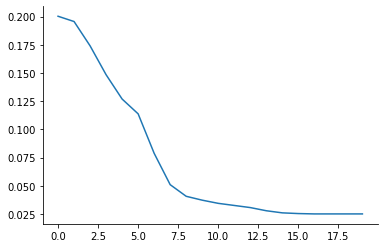

In [53]:
model = OddFiringModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

import matplotlib.pyplot as plt
m1_losses = train(model, data)
plt.plot(m1_losses)

## Step 4: Training a model with neuron parameter optimization

That went well. But let's see how we can do with a model that uses parameter optimization as well. To begin with, let us try to optimize on the `tau_mem_inv` parameter.

In [54]:
class OddFiringModelWithParameters(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        p1 = norse.LIFParameters(
            # 100 neurons in layer 1
            tau_mem_inv = torch.nn.Parameter(torch.full((200,), torch.as_tensor(1.0 / 1e-2))) 
        )
        p2 = norse.LIFParameters(
            # 100 neurons in layer 2
            tau_mem_inv = torch.nn.Parameter(torch.full((100,), torch.as_tensor(1.0 / 1e-2)))
        )
        self.model = norse.SequentialState(
            torch.nn.Linear(100, 200),
            norse.LIF(p=p1),
            torch.nn.Linear(200, 100),
            norse.LIF(p=p2),
        )
        
    def forward(self, x):
        return self.model(x)

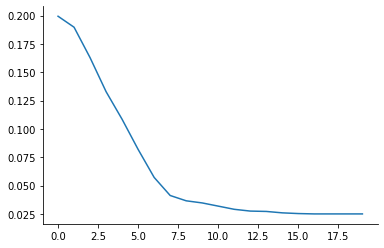

In [55]:
model = OddFiringModelWithParameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
m2_losses = train(model, data)
plt.plot(m2_losses)

This model will learn slightly faster, as we can see when we compare the two graphs:

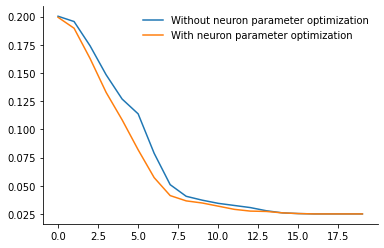

In [56]:
plt.plot(m1_losses, label="Without neuron parameter optimization")
plt.plot(m2_losses, label="With neuron parameter optimization")
plt.gca().legend()

Note, you might get different results, depending on the randomized initialization of the parameters. If the graphs look weird, try re-running the training.

## Step 5: Free experimentation and discussion

We have now understood how neuron parameters are represented in Norse, how we can use the optimizer in PyTorch to optimize *on the neuron parameters*, and how we can train spiking neural networks using such an optimizer.

There are much more interesting problems one could solve with this. The remainder of the workshop is meant to explore some of these. So, here are a few challenges to you in the final ~10 minutes:

* What happens if you used another parameter for optimization? For instance, the `v_reset`?
* What happens if you use a recurrent neuron model? For instance the `LIFRecurrent`?
* Discuss with your peers: does neuron parameter optimization exist in nature? Will we see different values for, say, the membrane time constant parameter in the brain?
* Discuss with your peers: how can you apply this to your own work? Or to the work of your peers?

## Step 6: Conclusion

This concludes the workshop on parameter learning. We hope it was helpful and we deeply appreciate your attention.

![](https://raw.githubusercontent.com/norse/norse/master/logo.png)